In [115]:
library(urbnmapr)
library(dplyr)
library(tidyr)
library(readr)
library(stringr)
library(ggplot2)
library(scales)
fp <- '/nfs/sloanlab004/projects/covid_mobility_proj/data/'
model_save_location = '/nfs/sloanlab004/projects/covid_mobility_proj/models'
split_model <- readRDS(str_c(model_save_location, 'did_sgnhd_both_split.rds'))
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/social_adj_matrix.RData')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/geo_adjacency_matrix.Rdata')
source("../utils/labels_and_colors.r")
census_data <- read_csv(str_c(fp, 'census_data/cc-est2018-alldata.csv'))

Parsed with column specification:
cols(
  .default = col_double(),
  SUMLEV = col_character(),
  STATE = col_character(),
  COUNTY = col_character(),
  STNAME = col_character(),
  CTYNAME = col_character()
)

See spec(...) for full column specifications.



In [116]:
get_urbn_map("states") %>% 
  mutate(state_fips = as.numeric(state_fips)) %>% 
  group_by(state_fips, state_name, state_abbv) %>% 
  summarise(n = n()) %>% 
  dplyr::select(-n) %>% 
  mutate(state_region = case_when(state_abbv %in% c('AK', 'HI', 'WA', 'OR', 'CA', 'NV', 'ID', 'MT',
                                             'WY', 'UT', 'CO', 'AZ', 'NM') ~ 'West',
                            state_abbv %in% c('ND', 'MN', 'SD', 'IA', 'NE', 'MO', 'KS', 'WI',
                                             'IL', 'IN', 'MI', 'OH') ~ 'Midwest',
                            state_abbv %in% c('OK', 'TX', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY',
                                             'WV', 'MD', 'DE', 'DC', 'VA', 'NC', 'SC', 'GA',
                                             'FL') ~ 'South',
                            state_abbv %in% c('PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME') ~ 'Northeast',
                            TRUE ~ 'Messed up')) -> states

In [117]:
social_influence_ranking <- as.data.frame(social_adj_matrix_state) %>% 
  mutate(user_state = colnames(social_adj_matrix_state)) %>%
  gather(key = 'fr_state', value = 'w', -user_state) %>% 
  mutate(user_state = as.numeric(user_state),
         fr_state = as.numeric(fr_state)) %>%
  left_join(., states, by = c('user_state' = 'state_fips')) %>% 
  mutate(user_state_name = state_name,
         user_state_abbv = state_abbv,
        user_state_region = state_region) %>% 
  dplyr::select(user_state, fr_state, w, user_state_name, user_state_abbv, user_state_region) %>%
  left_join(., states, by = c('fr_state' = 'state_fips')) %>% 
  mutate(fr_state_name = state_name,
         fr_state_abbv = state_abbv,
         fr_state_region = state_region) %>% 
  dplyr::select(-state_name, -state_abbv, -state_region) %>% 
  filter(user_state != fr_state) %>%
  group_by(user_state) %>% 
  arrange(desc(w)) %>% 
  mutate(influence_rank = row_number()) %>% 
  ungroup() %>% 
  dplyr::select(user_state_name, user_state_abbv, user_state_region, 
                fr_state_name, fr_state_abbv, fr_state_region, 
                influence_rank, w) %>% 
  arrange(user_state_name, influence_rank)

In [118]:
geo_influence_ranking <- as.data.frame(geo_bayes_state_level) %>% 
  mutate(dest_state = colnames(geo_bayes_state_level)) %>%
  gather(key = 'origin_state', value = 'w', -dest_state) %>% 
  mutate(origin_state = as.numeric(origin_state),
         dest_state = as.numeric(dest_state)) %>%
  left_join(., states, by = c('dest_state' = 'state_fips')) %>% 
  mutate(dest_state_name = state_name,
         dest_state_abbv = state_abbv,
        dest_state_region = state_region) %>% 
  dplyr::select(dest_state, origin_state, w, dest_state_name, dest_state_abbv, dest_state_region) %>%
  left_join(., states, by = c('origin_state' = 'state_fips')) %>% 
  mutate(origin_state_name = state_name,
         origin_state_abbv = state_abbv,
        origin_state_region = state_region) %>% 
  dplyr::select(-state_name, -state_abbv, -state_region) %>% 
  filter(origin_state != dest_state) %>%
  group_by(dest_state) %>% 
  arrange(desc(w)) %>% 
  mutate(influence_rank = row_number()) %>% 
  ungroup() %>% 
  dplyr::select(dest_state_name, dest_state_abbv, dest_state_region, 
                origin_state_name, origin_state_abbv, origin_state_region, influence_rank, w) %>% 
  arrange(dest_state_name, influence_rank)

In [119]:
census_data %>% 
  filter(YEAR == 11) %>%
  group_by(STATE) %>% 
  summarise(n = sum(TOT_POP)) %>% 
  ungroup() %>%
  mutate(STATE = as.numeric(STATE)) %>% 
  left_join(., states, by=c('STATE' = 'state_fips')) %>% 
  dplyr::select(state_name, state_abbv,n) -> state_populations

In [120]:
diff_state_social_coef <- split_model$coef[rownames(split_model$coef) == 'alter_sh_diff_state.r']
diff_state_geo_coef <- split_model$coef[rownames(split_model$coef) == 'geo_alter_sh_diff_state.r']

same_state_social_coef <- split_model$coef[rownames(split_model$coef) == 'alter_sh_same_state.r']
same_state_geo_coef <- split_model$coef[rownames(split_model$coef) == 'geo_alter_sh_same_state.r']
own_county_coef <- split_model$coef[rownames(split_model$coef) == 'stay_home.r']
total_effect_own_state = same_state_social_coef + same_state_geo_coef + own_county_coef

In [121]:
total_influence_ranking <- social_influence_ranking %>% 
  mutate(social_coef = w*diff_state_social_coef) %>% 
  left_join(., geo_influence_ranking, by=c('user_state_name' = 'dest_state_name',
                    'user_state_abbv' = 'dest_state_abbv',
                   'fr_state_name' = 'origin_state_name',
                   'fr_state_abbv' = 'origin_state_abbv')) %>% 
  mutate(geo_coef = w.y*diff_state_geo_coef,
         focal_state_name = user_state_name,
         focal_state_abbv = user_state_abbv,
         focal_state_region = user_state_region,
         alter_state_name = fr_state_name,
         alter_state_abbv = fr_state_abbv,
         alter_state_region = fr_state_region,
         social_rank = influence_rank.x,
         geo_rank = influence_rank.y) %>% 
  dplyr::select(focal_state_name, focal_state_abbv, focal_state_region, 
                alter_state_name, alter_state_abbv, alter_state_region,
               social_rank, geo_rank, social_coef, geo_coef) %>% 
  mutate(total_coef = social_coef + geo_coef) %>% 
  group_by(focal_state_name, focal_state_abbv) %>% 
  arrange(total_coef) %>% 
  mutate(total_rank = row_number()) %>% 
  ungroup() %>% 
  arrange(focal_state_name, total_rank)

In [122]:
total_influence_ranking_outbound <- social_influence_ranking %>% 
  mutate(social_coef = w*diff_state_social_coef) %>% 
  left_join(., geo_influence_ranking, by=c('user_state_name' = 'dest_state_name',
                    'user_state_abbv' = 'dest_state_abbv',
                   'fr_state_name' = 'origin_state_name',
                   'fr_state_abbv' = 'origin_state_abbv')) %>% 
  mutate(geo_coef = w.y*diff_state_geo_coef,
         focal_state_name = user_state_name,
         focal_state_abbv = user_state_abbv,
         focal_state_region = user_state_region,
         alter_state_name = fr_state_name,
         alter_state_abbv = fr_state_abbv,
         alter_state_region = fr_state_region,
         social_rank = influence_rank.x,
         geo_rank = influence_rank.y) %>% 
  dplyr::select(focal_state_name, focal_state_abbv, focal_state_region,
                alter_state_name, alter_state_abbv, alter_state_region,
               social_rank, geo_rank, social_coef, geo_coef) %>% 
  mutate(total_coef = social_coef + geo_coef) %>% 
  group_by(alter_state_name, alter_state_abbv) %>% 
  arrange(total_coef) %>% 
  mutate(total_rank = row_number()) %>% 
  ungroup() %>% 
  arrange(alter_state_name, total_rank)

In [123]:
state_influence_ranking <- social_influence_ranking %>% 
  mutate(social_coef = w*diff_state_social_coef) %>% 
  left_join(., geo_influence_ranking, by=c('user_state_name' = 'dest_state_name',
                    'user_state_abbv' = 'dest_state_abbv',
                   'fr_state_name' = 'origin_state_name',
                   'fr_state_abbv' = 'origin_state_abbv')) %>% 
  mutate(geo_coef = w.y*diff_state_geo_coef,
         focal_state_name = user_state_name,
         focal_state_abbv = user_state_abbv,
         focal_state_region = user_state_region,
         alter_state_name = fr_state_name,
         alter_state_abbv = fr_state_abbv,
         alter_state_region = fr_state_region,
         social_rank = influence_rank.x,
         geo_rank = influence_rank.y) %>% 
  dplyr::select(focal_state_name, focal_state_abbv, focal_state_region,
                alter_state_name, alter_state_abbv, alter_state_region,
               social_rank, geo_rank, social_coef, geo_coef) %>% 
  mutate(total_coef = social_coef + geo_coef) %>% 
  group_by(alter_state_name, alter_state_abbv) %>% 
  arrange(total_coef) %>% 
  mutate(total_rank = row_number()) %>% 
  ungroup() %>%  
  left_join(., state_populations, by=c('focal_state_name' = 'state_name',
                                       'focal_state_abbv' = 'state_abbv')) %>% 
  mutate(effect = exp(total_coef)-1,
         scaled_effect = effect*n) %>% 
  group_by(alter_state_name, alter_state_abbv) %>% 
  summarise(total_scaled_effect = sum(scaled_effect)) %>% 
  ungroup() %>% 
  arrange(total_scaled_effect) %>% 
  mutate(rank = row_number())

In [114]:
saveRDS(state_influence_ranking, file='../output/state_influence_ranking.rds')
saveRDS(total_influence_ranking_outbound, file='../output/influence_outbound.rds')
saveRDS(total_influence_ranking, file='../output/influence.rds')

In [124]:
influence_cdf <- total_influence_ranking %>% 
  filter(total_rank == 1) %>%
  mutate(absolute_indirect_effect = exp(total_coef)-1,
         absolute_direct_effect = exp(total_effect_own_state)-1,
        spillover = absolute_indirect_effect/absolute_direct_effect) %>%
  ggplot(., aes(x=spillover)) + stat_ecdf() + xlim(0,1) + 
  xlab('Spillover size') + ylab('Cumulative fraction of state pairs')

In [100]:
ggsave(
  paste0("../output/influence_cdf.pdf"),
  plot = influence_cdf,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 5,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

In [101]:
poa_cdf <- total_influence_ranking %>% 
  filter(total_rank == 1) %>%
  mutate(absolute_indirect_effect = exp(total_coef)-1,
         absolute_direct_effect = exp(total_effect_own_state)-1,
        spillover = absolute_indirect_effect/absolute_direct_effect,
        poa = 1/(1-spillover^2)) %>%
  ggplot(., aes(x=poa)) + stat_ecdf() + 
  xlab('Price of anarchy') + ylab('Cumulative fraction of state pairs')

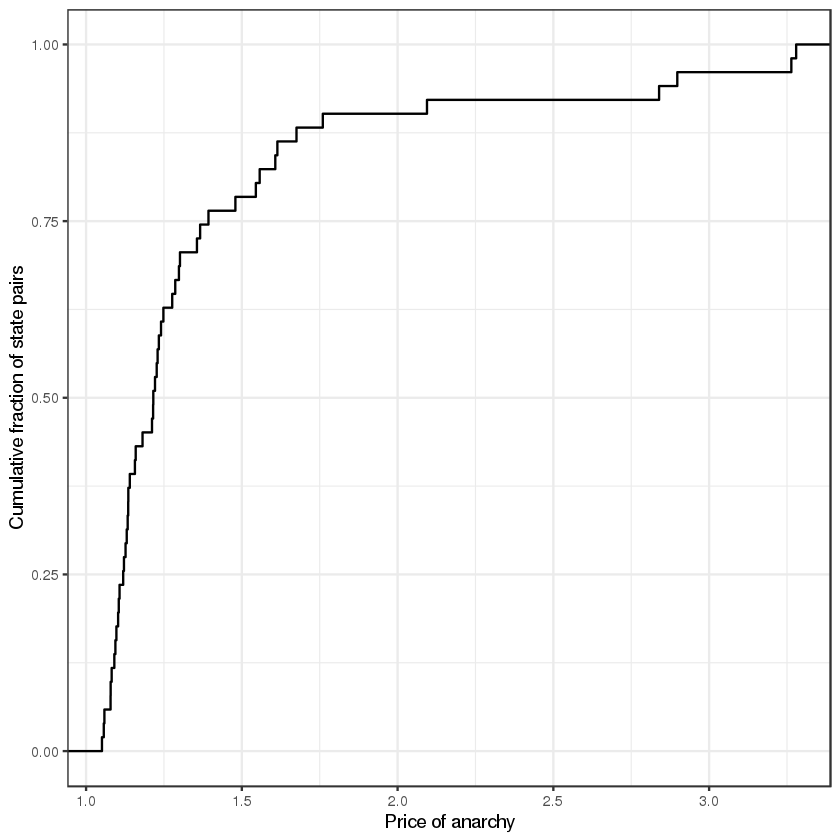

In [102]:
poa_cdf

In [103]:
ggsave(
  paste0("../output/poa_cdf.pdf"),
  plot = poa_cdf,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 5,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

Warning message:
“Ignoring unknown parameters: scaled”


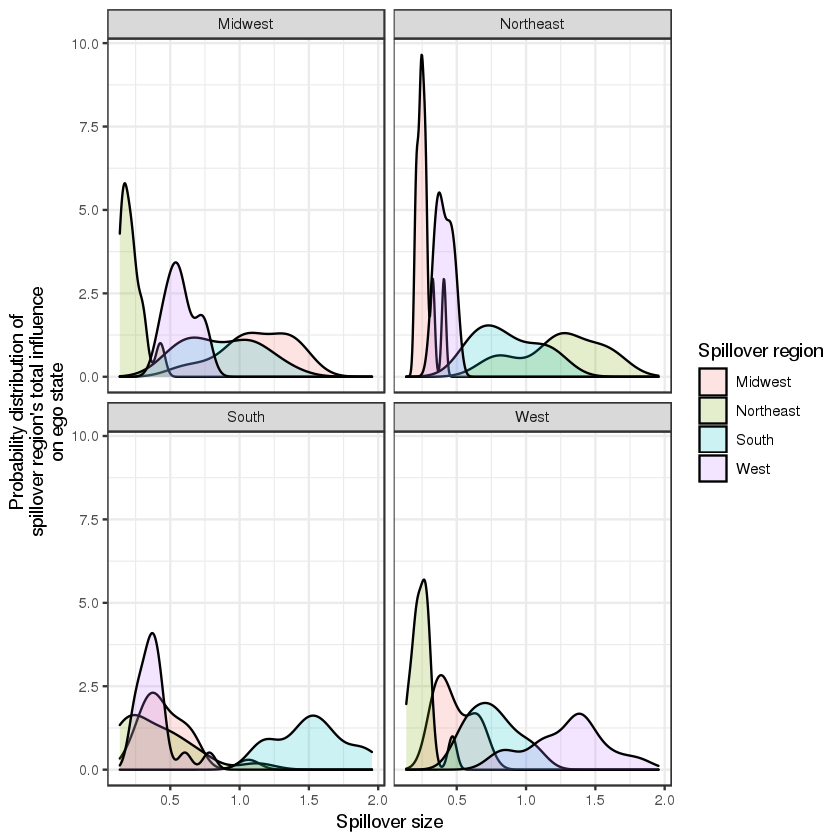

In [131]:
influence_by_region <- total_influence_ranking %>% 
  group_by(focal_state_abbv, focal_state_name, focal_state_region,
           alter_state_region) %>% 
  summarise(total_coef = sum(total_coef)) %>% 
  mutate(absolute_indirect_effect = exp(total_coef)-1,
         absolute_direct_effect = exp(total_effect_own_state)-1,
        spillover = absolute_indirect_effect/absolute_direct_effect) %>% 
  ggplot(., aes(x=spillover, fill=alter_state_region)) + geom_density(alpha=.2, scaled=TRUE) + facet_wrap(~focal_state_region) + 
  xlab('Spillover size') + ylab(str_wrap("Probability distribution of spillover region's total influence on ego state", 36)) + 
  labs(fill = "Spillover region")
influence_by_region

In [133]:
ggsave(
  paste0("../output/influence_by_region.pdf"),
  plot = influence_by_region,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 8,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

In [106]:
state_influence_scatter <- state_influence_ranking %>% 
  dplyr::left_join(state_populations, by=c('alter_state_name' = 'state_name',
                    'alter_state_abbv' = 'state_abbv')) %>% 
  ggplot(., aes(x=n, y=-1*total_scaled_effect, label=alter_state_abbv)) + geom_text() + 
  stat_smooth(method='lm', se=FALSE) + xlab('Population') + 
  ylab(str_wrap('Nationwide mobility impact from implementing shelter-in-place', 26)) + 
scale_y_log10(labels=comma) + scale_x_log10(labels=comma)

In [107]:
ggsave(
  paste0("../output/state_influence_scatter.pdf"),
  plot = state_influence_scatter,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 5,
  height = 5,
  units = c("in"),
  dpi = 200,
  limitsize = FALSE,
  useDingbats=FALSE
)

`geom_smooth()` using formula 'y ~ x'

